# ETL: Preprocess all the font data and prepare a clean pickle that can be used for training
- Judiciously cut 3 images from 3 x 1 images 
- Transform text from Black on White to White on Black
- Normalize the image data to values from 0.0 to 1.0

## Images
- 3 x 1 images with 3 characters have: 
  - Width:  150 pixels
  - Height:  50 pixels
- 1 x 1 images with 1 character have
  - Width:   50 pixels
  - Height:  50 pixels

---
Francois Robert

In [1]:
import imageio
import numpy as np
import os
from pathlib import Path
from six.moves import cPickle as pickle
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

seed1 = 128
np.random.seed(seed1)

In [2]:
from platform import python_version

print(f'python: {python_version()}')

python: 3.8.3


## Input and Output files

In [3]:
BASEDIR = ".."

# Input 
# Directory where all the font directories are copied from the data generated by my GenerateFontImages MacOS app.
FONT_DATA_DIR = os.path.join(BASEDIR, "data", "font_data")

# Output
# Create output Pickle directory
PICKLE_DIR = os.path.join(BASEDIR, "pickles")
Path(PICKLE_DIR).mkdir(parents=True, exist_ok=True)

OUT_DATAFILE = os.path.join(PICKLE_DIR, 'font.pickle')

# Functions

In [4]:
# Functions for getting array of directory paths and array of file paths
def get_dir_paths(root):
    return [os.path.join(root, n) for n in sorted(os.listdir(root)) if os.path.isdir(os.path.join(root, n))]


def get_file_paths(root):
    return [os.path.join(root, n) for n in sorted(os.listdir(root)) if os.path.isfile(os.path.join(root, n))]

In [5]:
def normalize_image(image, pixel_depth):
    """
    Normalize image for all pixels. 0-255 -> 0.0-1.0
    """

    try:
        array = imageio.imread(image)
    except ValueError:
        raise

    return 1.0 - (array.astype(float)) / pixel_depth  # (1 - x) will make it white on black

In [6]:
def get_exact_image_size(image_data):
    """
    Find out where are the non white pixels in the image
    """
    mask = image_data != 0.0
    coords = np.argwhere(mask)

    x_min, y_min = coords.min(axis=0)
    x_max, y_max = coords.max(axis=0) + 1
    return x_min, x_max, y_min, y_max

In [7]:
def load_one_font_data(dir, image_size, pixel_depth, 
                       verbose=False, 
                       min_nb_images=1):
    """
    Function to load all data for a single font
    We will load:
    - 1x1 images containing 1 character
    - 3x1 images containing 3 characters
    Note: 
    - For pictures, we typically describe them by width x height.
    - For 2D Matrix, we typically describe them by row x colum.
    This explains why we talk about a 1x3 matrix for a 3x1 image.
    """

    if verbose:
        print(dir)

    image_files = get_file_paths(dir)

    out_images = []
    
    image_index = 0
    for image in image_files:
        try:
            image_data_all_channels = normalize_image(image, pixel_depth)
            image_data = image_data_all_channels[:, :, 0]

            # Images proportions can be 1x1 or 3x1
            if image_data.shape != (image_size, image_size):
                # Process 3x1 image
                if image_data.shape != (image_size, 3 * image_size):
                    raise Exception(f'Unexpected image shape: {str(image_data.shape)}')
                else:
                    # We consider 3 x 1 image as a kind of elongated font "dough" in which
                    # we will cut 3 images:
                    # - a center image
                    # - a left image that will start where the first pixel is actually drawn
                    # - a right image that will end where the last pixel is actually drawn

                    # Images has: width:3 x height:1
                    x_min, x_max, y_min, y_max = get_exact_image_size(image_data)

                    # Center Image
                    # Find the first and last column to use in the 3 x 1 image
                    center_min_j = max(y_min, image_size*1)
                    center_max_j = min(y_max, image_size*2)

                    center_image = np.zeros((image_size, image_size))
                    center_image[x_min:x_max, center_min_j - image_size:center_max_j - image_size] = image_data[x_min:x_max, center_min_j:center_max_j]
                    out_images.append(center_image)

                    # Left Image
                    left_min_j = max(y_min - 2, 0)  # Keep a 2 pixels margin on the left
                    left_max_j = left_min_j + image_size

                    left_image = np.zeros((image_size, image_size))
                    left_image[x_min:x_max, :] = image_data[x_min:x_max, left_min_j:left_max_j]
                    out_images.append(left_image)

                    # Right Image
                    right_max_j = min(y_max + 2, image_size*3)  # Keep a 2 pixels margin on the right
                    right_min_j = right_max_j - image_size

                    right_image = np.zeros((image_size, image_size))
                    right_image[x_min:x_max, :] = image_data[x_min:x_max, right_min_j:right_max_j]
                    out_images.append(right_image)

            else:
                # Process 1 x 1 image
                out_images.append(image_data)
        except Exception as error:
            print(error)
            print('Skipping because of not being able to read: ', image)

    # Put all of our output images in a numpy array. 
    # Note: There is probably a more efficient way to do that
    nb_output_images = len(out_images)        
    dataset = np.ndarray(shape=(nb_output_images, image_size, image_size), dtype=np.float32) 
    for image_index in range(nb_output_images):
        dataset[image_index, :, :] = out_images[image_index]
            
    if nb_output_images < min_nb_images:
        raise Exception(f'Fewer images than expected: {nb_output_images} < {min_nb_images}')

    if verbose:
        print('Full dataset tensor: ', dataset.shape)
        print('Mean: ', np.mean(dataset))
        print('Standard deviation: ', np.std(dataset))

    return dataset

In [8]:
def transform_all_font_data(pathnames, image_size, pixel_depth, 
                            verbose=False,
                            min_nb_images=1):
    """
    Load data (images and labels) of all fonts
    """
    
    result = {} # The font names will be the keys of dict. The values are all the images for that font
    for full_filepath in tqdm(pathnames):
        filename = os.path.basename(full_filepath)
        dataset  = load_one_font_data(full_filepath, image_size, pixel_depth,
                                      verbose=verbose,
                                      min_nb_images=min_nb_images) 
        result[filename] = dataset
    return result

In [9]:
# Produce clean image data and labels. Also keep the list of font names.
def finalize_image_packaging(all_data, image_size):
    """
    Produce clean image data and labels. Also keep the list of font names.
    """
    
    images     = []
    labels     = []
    font_names = []

    nb_fonts = len(all_data)

    for label, font_name in enumerate(all_data):
        letter_data = all_data[font_name]

        # All images
        images.extend(letter_data)
        # all labels (integer value)
        labels.extend([label] * len(letter_data))
        # Keep the font names
        font_names.append(font_name)

    images = np.array(images)
    labels = np.array(labels)

    return images, labels, font_names

In [10]:
def save_to_pickle(pickle_file, object, force=True):
    """
    Save an object to a pickle file
    """       
    if os.path.exists(pickle_file) and not force:
        print(f'{pickle_file} already present, skipping pickling')
    else:
        try:
            with open(pickle_file, 'wb') as file:
                pickle.dump(object, file, pickle.HIGHEST_PROTOCOL)
        except Exception as e:
            print(f'Unable to save object to {pickle_file}: {e}')
            raise            

In [11]:
def show_one_image(full_filename):
    img = mpimg.imread(full_filename)
    imgplot = plt.imshow(img)
    plt.show() 

In [12]:
def plot_sample(image, axs):
    axs.imshow(image.reshape(image_size, image_size), cmap="gray")
    
def display_images(X):
    """ 
    This function shows images with their real labels
    """

    fig = plt.figure(figsize=(13, 9))
    fig.subplots_adjust(hspace=0.1,wspace=0.1,
                        left=0,right=1,bottom=0, top=1)

    nb_pictures = len(X)
    nb_per_row  = 10
    nb_of_row   = (nb_pictures - 1) // nb_per_row + 1    

    for i in range(nb_pictures):
        ax = fig.add_subplot(nb_of_row , nb_per_row, i+1, xticks=[], yticks=[]) 
        plot_sample(X[i].reshape((image_size, image_size)), ax)
    plt.show() 

## Get ready for preprocessing

In [13]:
# Get directory and file paths of font images
font_data_paths = get_dir_paths(FONT_DATA_DIR)

# Set image properties
image_size  = 50  # Pixel width and height
pixel_depth = 255.0  # Number of levels per pixel

## Show a few images as they are in the input directory

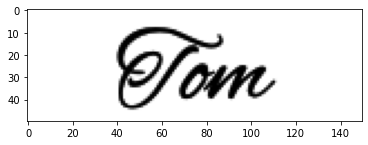

In [14]:
files = get_file_paths(font_data_paths[1]) 
show_one_image(files[222])

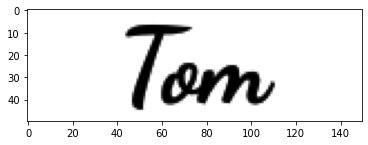

In [15]:
files = get_file_paths(font_data_paths[15]) 
show_one_image(files[222])

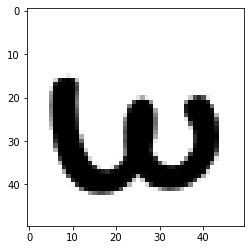

In [16]:
files = get_file_paths(font_data_paths[19]) 
show_one_image(files[310])

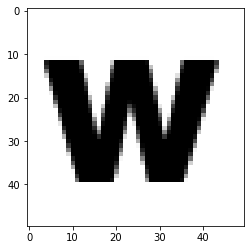

In [17]:
files = get_file_paths(font_data_paths[22]) 
show_one_image(files[310])

# Do ETL
## Extract and Transform all images and labels in a dictionary

In [18]:
all_data = transform_all_font_data(font_data_paths, image_size, pixel_depth, verbose=False)

100%|██████████| 35/35 [00:11<00:00,  3.00it/s]


In [19]:
print("nb fonts: ", len(all_data))

nb fonts:  35


## Generate all datasets (images) and labels

In [20]:
images, labels, font_names = finalize_image_packaging(all_data, image_size)

In [21]:
# Show dimensions of datasets and labels
print(f"Images: {images.shape}, labels: {labels.shape}")

Images: (29050, 50, 50), labels: (29050,)


## Show images that are ready to use for Training

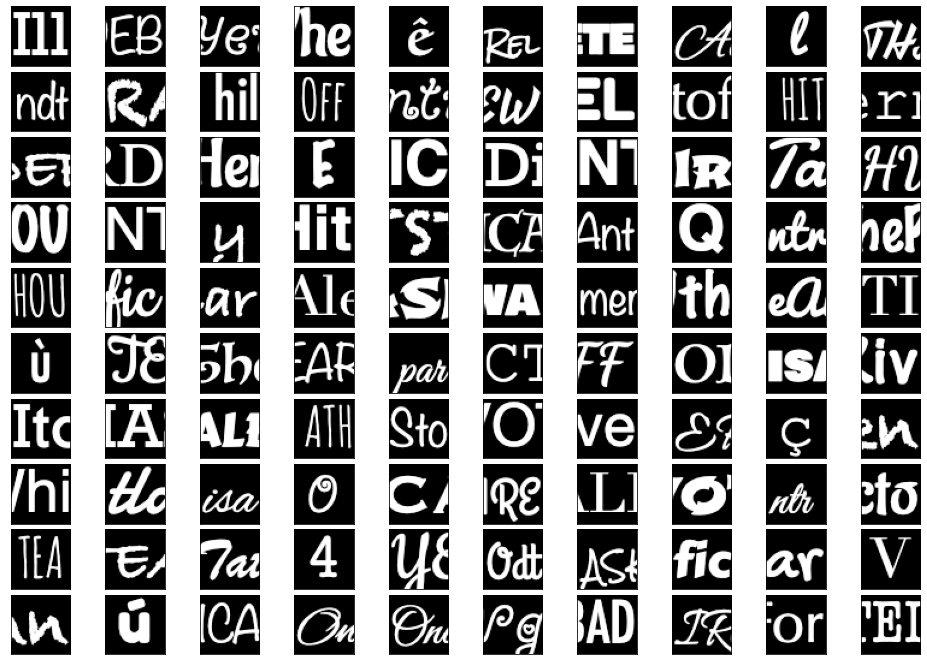

In [22]:
# Show some of the resulting images.
# Note that all images are now: 50 pixels x 50 pixels x 1 channel
indices = np.random.choice(images.shape[0], 100, replace=False)
display_images(images[indices])

In [23]:
# Save images, labels and font names to single pickle file
save_to_pickle(
    OUT_DATAFILE,
    {
        'images': images,
        'labels': labels,
        'font_names': font_names
    }
)

In [24]:
print("Data for Training is in file:", OUT_DATAFILE)

Data for Training is in file: ../pickles/font.pickle


### ETL Completed